In [1]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
import pymaster as nmt
%matplotlib inline
#import packages

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [2]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128

npix = hp.nside2npix(nside)

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [3]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined

print(maps_pl.shape)

(9, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [4]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
almsize=hp.Alm.getsize(lmax)
print(almsize)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freqs, almsize), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values

for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    

73920
147456
383


Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l
$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [5]:
C_l= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float)#lmax+1 x freq x freq
for l in range(lmax+1):
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0


    #alm = np.conj(alm_p) + alm_p #alm with positive and negative values

    C_l [l,:, :]= np.real(np.outer(alm_p[:, 0], alm_p[:,0])) #2d array from outer product alm_0
    
    for m in range(1,l+1): #sum over m
        C_l [l,:, :] += 2* np.real(np.outer(alm_p[:, m], np.conj(alm_p[:, m]))) #adding alm_p and negative ti C_l . outer product/multiplying over freq
C_l /= (2*l +1)   

print(alm_p.shape)
print(C_l.shape)

(9, 384)
(384, 9, 9)


Add a galaxy cut to get rid of emissions from the galactic plane. Create Mask

In [6]:
gal_cut = np.radians(10)
mask = np.zeros(npix, dtype=np.float32)
mask[hp.query_strip(nside, np.pi/2-gal_cut, np.pi/2+gal_cut)] = 1
#mask[hp.query_disc(nside, hp.ang2vec(np.pi/2, 0), np.radians(20))] = 1
print(mask.shape)
mean=np.mean(1-mask)#mean of the mask
print(mean)


(196608,)
0.8255208


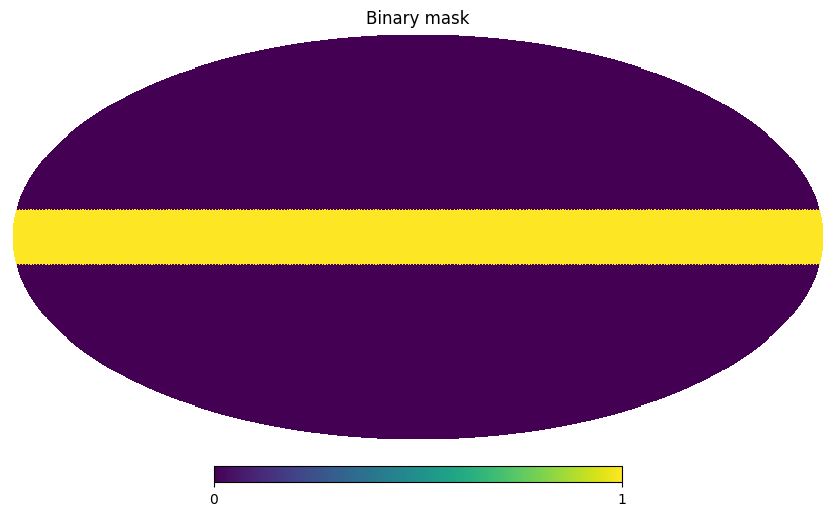

In [7]:
hp.mollview(mask, title="Binary mask")

Initializing field with mask

In [9]:
f_0 =nmt.NmtField(1-mask, [maps_pl[3,:]])

Pseudo C_l. C_l of masked field

In [10]:
pcl = nmt.compute_coupled_cell(f_0,f_0)
pcl2 =hp.anafast(masked)

print(pcl.shape) #1 power spectra with 384 multipoles
ells = np.arange(len(pcl[0]))
print(ells.shape)

(1, 384)
(384,)


No binning scheme

In [11]:
b = nmt.NmtBin.from_nside_linear(nside, 1)

Mode Coupling Matrix

(384, 384)


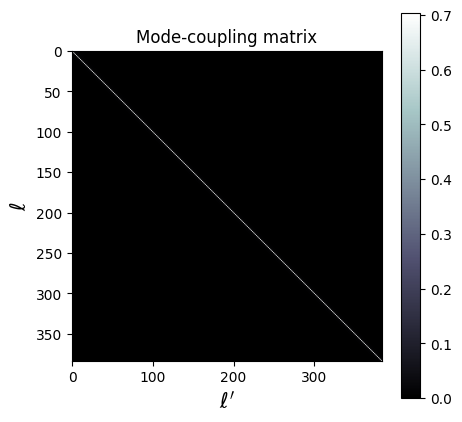

In [12]:
# Create a NaMaster workspace
w = nmt.NmtWorkspace.from_fields(f_0, f_0, b)

# Extract the mode-coupling matrix
mcm = w.get_coupling_matrix()
print(mcm.shape)

# Plot MCM
plt.figure(figsize=(5, 5))
plt.title('Mode-coupling matrix')
plt.imshow(mcm, cmap='bone')
#plt.plot(mcm[40,:])
plt.ylabel("$\\ell$", fontsize=15)
plt.xlabel("$\\ell'$", fontsize=15)
plt.colorbar()
plt.show()

Invert the mode coupling matrix

In [13]:
mcm_inv= np.linalg.pinv(mcm)
print(mcm_inv.shape)

(384, 384)


Decoupled power spectra $C_l^* = M_{ll'}^{-1} \tilde{C}_l$

In [14]:
cl_dec = np.dot(mcm_inv, pcl[0])
print(cl_dec.shape)

(384,)


Decoupling the full sky CMB maps

In [23]:
Cl_cmb = hp.anafast(cmb_pl[0]) #input cmb map
f_cmb =nmt.NmtField(1-mask, [cmb_pl[0]])
pcl_cmb = nmt.compute_coupled_cell(f_cmb, f_cmb)
w_cmb = nmt.NmtWorkspace.from_fields(f_cmb, f_cmb, b)
mcm_cmb = w_cmb.get_coupling_matrix()
mcm_cmb_inv = np.linalg.pinv(mcm_cmb)
cmb_dec = np.dot(mcm_cmb_inv, pcl_cmb[0]) #decoupled cmb map



norm= (ells*(ells+1))/(2*np.pi)


In [ ]:
bin = nmt.NmtBin.from_nside_linear(nside, 4) #now with binning
cmb_bin = nmt.compute_full_master(f_cmb, f_cmb, bin)
ell_arr = bin.get_effective_ells() 
print(ell_arr.shape)
A =(ell_arr*(ell_arr+1))/(2*np.pi) #normalization factor adjusted for binning

(95,)


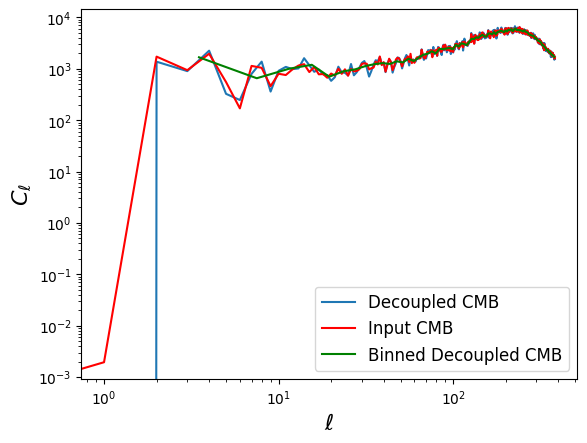

In [26]:
#plt.plot(ells, norm*cl_dec, label='Decoupled Cl')
#plt.plot(ells, (norm*pcl[0])/mean, label='Pseudo Cl')
plt.plot(ells, norm*cmb_dec, label='Decoupled CMB')
plt.plot(ells, norm*Cl_cmb, 'r-',label= 'Input CMB')
plt.plot(ell_arr, A*cmb_bin[0], 'g',label = "Binned Decoupled CMB")
#plt.plot(ell_arr, norm*cmb_bin, label = "Binned Decoupled CMB")
#plt.loglog
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=12)
plt.show()